In [13]:
# Imports and constants
import time
import traceback
import pandas as pd
import numpy as np
from sqlalchemy import MetaData
from sqlalchemy import create_engine, select, insert, event
from sqlalchemy.sql import text
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt

CHUNK_SIZE=10**6

GREEN = 'green'
YELLOW = 'yellow'
MIN_YEAR = 2020
MAX_YEAR = 2023

COLS = ['id', 
        'pickup_datetime', 'dropoff_datetime', 'ratecode_id', 
        'pu_location_id', 'do_location_id', 'passenger_count', 'trip_distance', 
        'fare_amount', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 
        'congestion_surcharge', 'improvement_surcharge', 'extra', 'payment_type']

# Functions
def getConnectionString():
    SERVER = 'tcp:nyc-taxi-2024.database.windows.net,1433'
    DATABASE = 'nyc_taxi_2024'
    USERNAME = 'ishmakwana'
    PASSWORD = 'xxx'

    return f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};UID={USERNAME};PWD={PASSWORD};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'

class TaxiDBReader:
    def __init__(self):
        self.md = MetaData()
        self.engn = create_engine(URL.create("mssql+pyodbc", query={"odbc_connect": getConnectionString()}))
        self.md.reflect(self.engn)
        self.year = MAX_YEAR
        self.taxi_type = YELLOW
        print('sql engine ready')

        with self.engn.connect() as conn:
            conn.rollback()

        @event.listens_for(self.engn, 'before_cursor_execute')
        def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
            # print(f'params: {params}')
            if executemany:
                cursor.fast_executemany = True

    def setTable(self, year=MAX_YEAR, taxi_type=YELLOW):
        self.year = year
        self.taxi_type = taxi_type

    def getTableName(self):
        postfix = '' if self.year == MIN_YEAR else self.year
        return f'{self.taxi_type}_taxi_trips{postfix}'
    

dr = TaxiDBReader()
        

sql engine ready


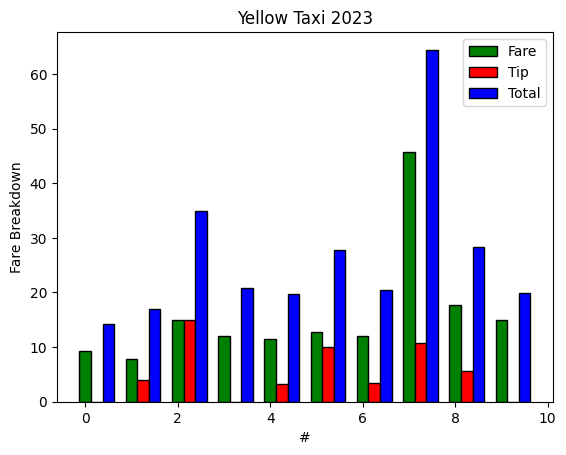

In [18]:
dr.setTable(year=2023, taxi_type=YELLOW)
table_name = dr.getTableName()

with dr.engn.connect() as conn:
    start = 0
    count = 10
    sql = text(f'SELECT * FROM {table_name} ORDER BY id OFFSET {start} ROWS FETCH NEXT {count} ROWS ONLY')
    df = pd.read_sql(sql, conn)

    r = np.arange(count) 
    width = 0.25

    plt.bar(r, df['fare_amount'], color = 'g', 
            width = width, edgecolor = 'black', 
            label='Fare') 
    plt.bar(r+width, df['tip_amount'], color = 'r', 
            width = width, edgecolor = 'black', 
            label='Tip') 
    plt.bar(r+2*width, df['total_amount'], color = 'b', 
            width = width, edgecolor = 'black', 
            label='Total') 
    
    plt.xlabel("#") 
    plt.ylabel("Fare Breakdown") 
    plt.title("Yellow Taxi 2023") 
    plt.legend()
    plt.show()

    



In [ ]:
# Future todos
# get average for fares / passenger count
# do sampling for time of day, or convert to daily data by average data for the day
# look for missing values